## Topic X: Bring your own topic!
You are encouraged to propose your own topic! Please note the following criteria:

• the topic should include a text classification task at its core and there should be some
annotated training data available for this task, otherwise milestones 1 and 2 cannot be
completed. If you are unsure whether your topic is suitable, we are happy to advise you.

• you are still required to work in teams of 4, so you should assemble a team to work on the
project (if necessary you can also bring in external members who are not registered for the
course)

• you should contact the exercise coordinator (G ́abor Recski) about your topic proposal, we
can discuss your ideas and recommend 1-2 instructors who can act as your mentors

# Import required packages 

In [5]:
import os
import pandas as pd
import conllu
from stanza.utils.conll import CoNLL
from stanza.models.common.doc import Document
import json
import re
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import stanza
import matplotlib.pyplot as plt
import seaborn as sns

/Users/saito/Documents/GitHub/NLP-DetecConstComm-project/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/saito/Documents/GitHub/NLP-DetecConstComm-project/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stanza.download('en')

[nltk_data] Downloading package punkt to /Users/saito/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /Users/saito/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /Users/saito/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-01-04 20:22:51 INFO: Downloaded file to /Users/saito/stanza_resources/resources.json
2025-01-04 20:22:51 INFO: Downloading default packages for language: en (English) ...
2025-01-04 20:24:27 INFO: Downloaded file to /Users/saito/stanza_resources/en/default.zip
2025-01-04 20:24:28 INFO: Finished downloading models and saved to /Users/saito/stanza_resources


# Import Data


In [8]:
# Data path
data_path = os.path.join('Data', 'C3_anonymized.csv')

# Import data
df = pd.read_csv(data_path)

# Observe Data

In [38]:
df.head(5)

,article_id,comment_author,comment_counter,comment_text,njudgements_constructiveness_expt,njudgements_toxicity_expt,agree_constructiveness_expt,agree_toxicity_expt,constructive,crowd_toxicity_level,...,constructive_characteristics,non_constructive_characteristics,toxicity_characteristics,crowd_comments_constructiveness_expt,crowd_comments_toxicity_expt,other_con_chars,other_noncon_chars,other_toxic_chars,constructive_binary,pp_comment_text
0,26023945,0,source1_26023945_62,And this Conservative strategy has produced the angry and desperate wing-nuts like the fellow who called reporters 'lying pieces of Sh*t' this week. The fortunate thing is that reporters were able to report it and broadcast it - which may shake up a few folks who recognize a bit of themselves somewhere in there and do some reflecting. I live in hope.,3.0,3.0,0.17,0.50,1.0,4.0,...,specific_points:3\ndialogue:2,no_non_con:3\nprovocative:1,abusive:3\npersonal_attack:1\nteasing:1\nembarrassment:1,\n\n,\n\n,\n\n,\n\n,\n\n,1.0,And this Conservative strategy has produced the angry and desperate wing-nuts like the fellow who called reporters lying pieces of Sh*t this week . The fortunate thing is that reporters were able to report it and broadcast it - which may shake up a few folks who recognize a bit of themselves somewhere in there and do some reflecting . I live in hope .
1,24565777,1,source1_24565777_106,"I commend Harper for holding the debates outside of a left-wing forum as this will help prevent the left from manipulating the debates to try to make Harper look bad. Indeed, we’ll finally have some fair debates. Trudeau is a coward and the only one who’s opposing this as he’s terrified about losing left-wing protection during the debates if the debates are held elsewhere. If Trudeau doesn’t have Chretien or Martin speaking for him or isn't currently in training to learn how to handle himself in a debate, he has May attending the debates to hold his little hand. If Trudeau can’t speak for himself or handle debates, how does he expect to run a country?",3.0,3.0,0.33,0.17,1.0,3.0,...,specific_points:3\ndialogue:2,no_non_con:2\nno_respect:1,abusive:1\npersonal_attack:1\nteasing:1\nembarrassment:1\nno_toxic:1,\n\n,\n\n,\n\n,\n\n,\n\n,1.0,"I commend Harper for holding the debates outside of a left-wing forum as this will help prevent the left from manipulating the debates to try to make Harper look bad . Indeed , we ’ ll finally have some fair debates . Trudeau is a coward and the only one who ’ s opposing this as he ’ s terrified about losing left-wing protection during the debates if the debates are held elsewhere . If Trudeau doesn ’ t have Chretien or Martin speaking for him or isnt currently in training to learn how to handle himself in a debate , he has May attending the debates to hold his little hand . If Trudeau can ’ t speak for himself or handle debates , how does he expect to run a country ?"
2,28775443,2,source1_28775443_136,"What a joke Rachel Notley is. This is what was posted on the NDP website on the last World Press Freedom Day. She can't even follow her own leader. She should resign. Immediately.“Today, we pay tribute to journalists who have lost their lives or been injured in the line of duty. It is unacceptable that, in 2015, journalists are still prosecuted, detained and assassinated for doing their jobs. Independent media is of immeasurable value in a free and democratic society, and it is our duty to ensure that this continues to be respected and protected.“We also take this opportunity to stand in solidarity with journalists and Canadians who have been affected by the Conservative’s reckless cuts to CBC/ Radio-Canada.“When we attack the freedom of the press, we’re attacking our own people, democracy and freedom.“New Democrats thank journalists and the media for their invaluable work informing the public. Let’s work together to defend freedom of the press.”http://www.ndp.ca/news/statement-ndp-world-press-freedom-day",3.0,3.0,0.83,0.00,1.0,3.0

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   article_id                            12000 non-null  int64  
 1   comment_author                        12000 non-null  int64  
 2   comment_counter                       12000 non-null  object 
 3   comment_text                          12000 non-null  object 
 4   njudgements_constructiveness_expt     12000 non-null  float64
 5   njudgements_toxicity_expt             12000 non-null  float64
 6   agree_constructiveness_expt           12000 non-null  float64
 7   agree_toxicity_expt                   12000 non-null  float64
 8   constructive                          12000 non-null  float64
 9   crowd_toxicity_level                  12000 non-null  float64
 10  has_content                           10000 non-null  object 
 11  crowd_discard  

What's the difference between column 'comment_text' and 'pp_comment_text':

Seems like it's a "pre-cleaned" text column:
- remove hyphen (')
- Added whitespace before-after points, coma, apostrophe 
- kept - in words such as 'left-wing'

In [7]:
for i in range(0,2):
    print("Comment text:\n",df["comment_text"][i],"\n\npp Comment text:\n",df["pp_comment_text"][i],"\n-----------------------------")

Comment text:
 And this Conservative strategy has produced the angry and desperate wing-nuts like the fellow who called reporters 'lying pieces of Sh*t' this week. The fortunate thing is that reporters were able to report it and broadcast it - which may shake up a few folks who recognize a bit of themselves somewhere in there and do some reflecting. I live in hope. 

pp Comment text:
 And this Conservative strategy has produced the angry and desperate wing-nuts like the fellow who called reporters lying pieces of Sh*t this week . The fortunate thing is that reporters were able to report it and broadcast it - which may shake up a few folks who recognize a bit of themselves somewhere in there and do some reflecting . I live in hope . 
-----------------------------
Comment text:
 I commend Harper for holding the debates outside of a left-wing forum as this will help prevent the left from manipulating the debates to try to make Harper look bad. Indeed, we’ll finally have some fair debates.

## Creating a dataset with untreated comment annotation about constructiveness (binary)

In [8]:
df_anno = df[['comment_text','constructive_binary']].copy()

#Change the constructive binary column to int (1 or 0)
df_anno['constructive_binary'] = df_anno['constructive_binary'].astype(int)

print(df_anno['constructive_binary'].value_counts())


constructive_binary
1    6516
0    5484
Name: count, dtype: int64


Let's look at some of the constructive and non-constructive comments

In [9]:
pd.set_option('display.max_colwidth', None)

# Randomly sample 3 constructive comments
random_constructive = df_anno[df_anno['constructive_binary'] == 1].sample(n=3, random_state=42)

# Randomly sample 3 non-constructive comments
random_non_constructive = df_anno[df_anno['constructive_binary'] == 0].sample(n=3, random_state=42)

# Display the results
print("Random Constructive Comments:")
print(random_constructive['comment_text'])
print("\nRandom Non-Constructive Comments:")
print(random_non_constructive['comment_text'])

Random Constructive Comments:
10541                                                                                                                                                                                                                                                                                                                                                                                                                                  The world & the west will be better when the Globalists are all voted out of office. They show very little concern for their own citizens and instead try to one-up each other by impressing the dictators or climate change zealots at the UN.
3140     Actions speak louder than words of condolence. Withdrawing was the wrong thing to do a week ago and its the wrong thing to do now. Giving in to the ruthless intimidation tactics of this cancer on humanity is exactly what ISIS is trying to achieve. It's time to stand with the Free-world and in part

Some possible issues that we saw:
- use of slang like "gonna, gunna" for "going to"
- abreviations
- spelling mistakes
- telling if a comment is constructive or not can be highly subjective. That's most likely why a non-binary annotation column exist, most fitted for a regression task

but overall the texts seems cleans in general

Now let's build a function to see which words are the most used

In [10]:
def summarize_most_used_words(text_list, top_n=10, language='english'):
    #Summarizes the most used words in a list of text, excluding stopwords.

    # Load the stopwords for the given language
    stop_words = set(stopwords.words(language))
    
    # Combine all texts into one large string
    all_text = ' '.join(text_list)
    
    # Convert to lowercase and remove punctuation using regex
    all_text_cleaned = re.sub(r'[^\w\s]', '', all_text.lower())
    
    # Split into words
    words = word_tokenize(all_text_cleaned, language=language)
    
    # Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]
    
    # Count word frequencies and get the most common
    word_counts = Counter(filtered_words)
    most_common_words = word_counts.most_common(top_n)
    
    return most_common_words, word_counts.__len__()


Let's see the most used words!

In [11]:
#Global
print("top 10 most used words (without stopwords):\n")
print(summarize_most_used_words(df_anno['comment_text'], top_n=10, language='english'))

#Constructive comments
print("\ntop 10 most used words (without stopwords) in constructive comments:\n")
print(summarize_most_used_words(df_anno[df_anno['constructive_binary']==1]['comment_text'], top_n=10, language='english'))

#Non-constructive comments
print("\ntop 10 most used words (without stopwords) in non-constructive comments:\n")
print(summarize_most_used_words(df_anno[df_anno['constructive_binary']==0]['comment_text'], top_n=10, language='english'))

top 10 most used words (without stopwords):

([('people', 2817), ('would', 2666), ('canada', 2528), ('harper', 2444), ('one', 2190), ('like', 2128), ('us', 1833), ('dont', 1691), ('government', 1654), ('get', 1566)], 36495)

top 10 most used words (without stopwords) in constructive comments:

([('people', 2464), ('would', 2265), ('canada', 2100), ('harper', 1837), ('one', 1824), ('like', 1706), ('us', 1597), ('government', 1427), ('dont', 1404), ('get', 1271)], 33124)

top 10 most used words (without stopwords) in non-constructive comments:

([('harper', 607), ('canada', 428), ('like', 422), ('would', 401), ('one', 366), ('people', 353), ('get', 295), ('globe', 288), ('dont', 287), ('trudeau', 276)], 13564)


A potential issue with this data is that many of the most frequently used words appear in both constructive and non-constructive comments. This occurs in different proportions because, as shown below, constructive comments tend to be longer than non-constructive ones.


| Rank | General Words         | Constructive Words       | Non-Constructive Words     |
|------|-----------------------|--------------------------|----------------------------|
| 1    | people (2817)         | people (2464)            | harper (607)               |
| 2    | would (2666)          | would (2265)             | canada (428)               |
| 3    | canada (2528)         | canada (2100)            | like (422)                 |
| 4    | harper (2444)         | harper (1837)            | would (401)                |
| 5    | one (2190)            | one (1824)               | one (366)                  |
| 6    | like (2128)           | like (1706)              | people (353)               |
| 7    | us (1833)             | us (1597)                | get (295)                  |
| 8    | dont (1691)           | government (1427)        | globe (288)                |
| 9    | government (1654)     | dont (1404)              | dont (287)                 |
| 10   | get (1566)            | get (1271)               | trudeau (276)              |

Also, it's likely that due to the length of the comments, constructive comments will have a larger vocabulary. This might cause a model to become biased, interpreting unknown words as constructive words.

| Category                | General Words | Constructive Words | Non-Constructive Words |
|-------------------------|---------------|--------------------|------------------------|
| Total Number of Words   | 36,493        | 33,124             | 13,562                 |

Now let's see if the character length and the average word length is different depending on if the comment is constructive or not

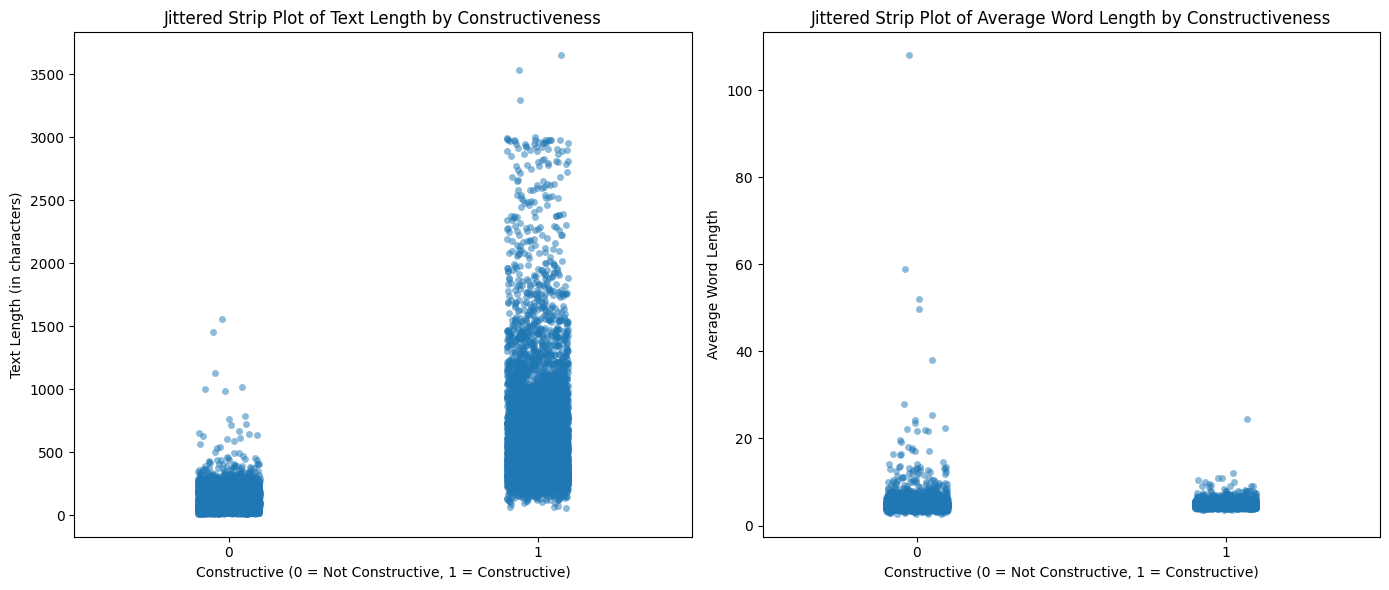

In [12]:
# Function to calculate the avg word length in a comment
def avg_word_length(text):
    words = text.split()
    if len(words) > 0:
        return sum(len(word) for word in words) / len(words)
    else:
        return 0

# Create a length column
df_anno['text_length'] = df_anno['comment_text'].apply(len)
df_anno['avg_word_length'] = df_anno['comment_text'].apply(avg_word_length)


# Create a figure with 2 subplots (1 row, 2 columns)
plt.figure(figsize=(14, 6))

# First plot: Jittered strip plot for text length
plt.subplot(1, 2, 1)
sns.stripplot(x='constructive_binary', y='text_length', data=df_anno, jitter=True, alpha=0.5)
plt.title('Jittered Strip Plot of Text Length by Constructiveness')
plt.xlabel('Constructive (0 = Not Constructive, 1 = Constructive)')
plt.ylabel('Text Length (in characters)')

# Second plot: Jittered strip plot for average word length
plt.subplot(1, 2, 2)
sns.stripplot(x='constructive_binary', y='avg_word_length', data=df_anno, jitter=True, alpha=0.5)
plt.title('Jittered Strip Plot of Average Word Length by Constructiveness')
plt.xlabel('Constructive (0 = Not Constructive, 1 = Constructive)')
plt.ylabel('Average Word Length')

# Adjust layout to prevent overlap
plt.tight_layout()

It's quite easy to see that constructive comments can lead to a big text, only a few non constructive comments go over 1000 characters while it's quite common for constructive ones. However the average world length plot is quite similar between the 2 classes, even though we see longer words in non constructive comments, which likely are mistakes (it would be surprising to find a comment where the average word length is above 100!). Let's find out about that last hypothesis.

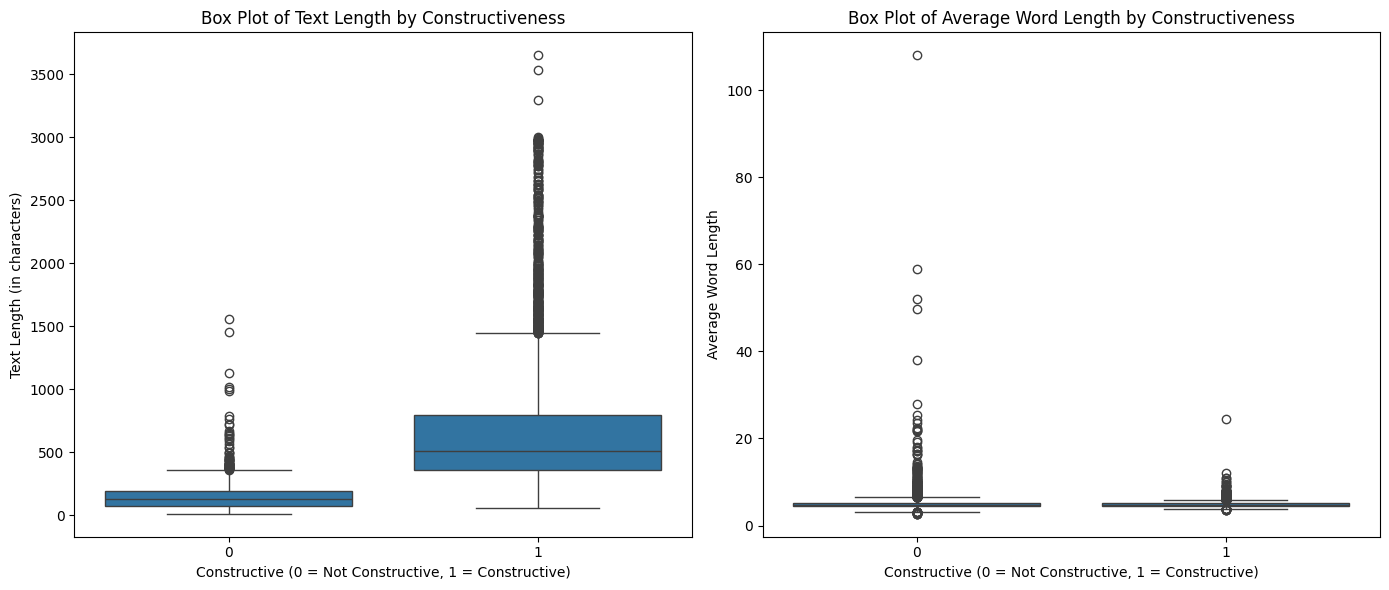

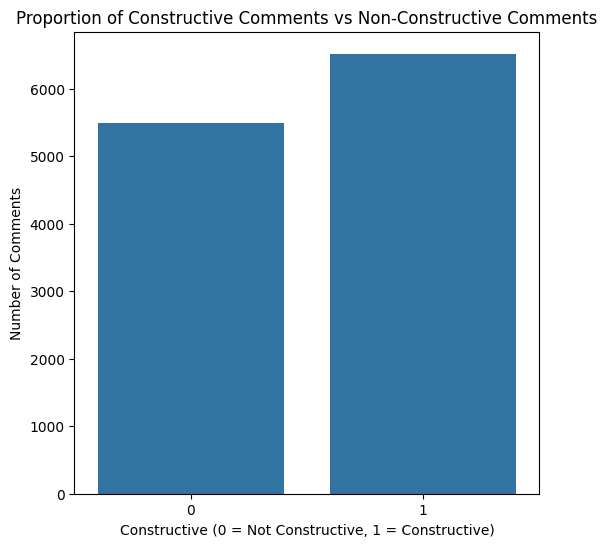

In [13]:
# Create a figure with 2 subplots (1 row, 2 columns)
plt.figure(figsize=(14, 6))

# First plot: Box plot for text length
plt.subplot(1, 2, 1)
sns.boxplot(x='constructive_binary', y='text_length', data=df_anno)
plt.title('Box Plot of Text Length by Constructiveness')
plt.xlabel('Constructive (0 = Not Constructive, 1 = Constructive)')
plt.ylabel('Text Length (in characters)')

# Second plot: Box plot for average word length
plt.subplot(1, 2, 2)
sns.boxplot(x='constructive_binary', y='avg_word_length', data=df_anno)
plt.title('Box Plot of Average Word Length by Constructiveness')
plt.xlabel('Constructive (0 = Not Constructive, 1 = Constructive)')
plt.ylabel('Average Word Length')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Plot proportion of constructive comments vs non-constructive comments
plt.figure(figsize=(6, 6))
sns.countplot(x='constructive_binary', data=df_anno)
plt.title('Proportion of Constructive Comments vs Non-Constructive Comments')
plt.xlabel('Constructive (0 = Not Constructive, 1 = Constructive)')
plt.ylabel('Number of Comments')

# Show the plot
plt.show()

In [14]:
long_word_comments = df_anno[df_anno['avg_word_length'] > 35]
for comment in long_word_comments['comment_text']:
    print(comment)

https://wikileaks.org/podesta-emails/emailid/7452#efmAAAAAv
www. thestar.com/news/canada/2013/04/29/thomas_mulcair_and_the_ndp_are_far_from_dead_in_quebec_hbert.html
Old stock? https://pbs.twimg.com/media/CPJbj0AUEAAA66Q.jpghttp://www.joeydevilla.com/wordpress/wp-content/uploads/2015/09/old-stock-vs-those-people.jpg
FYIhxxp://www.pm.gc.ca/eng/contact.asp
良い道徳心のカナダ人！私たちは、国レベル、地域レベルや地方レベルに存在する専制政治から私たちの国を解放しません。私たちの国は、ライディングレベルで救出されます。私はハーパー党を代表している人を破っての最善の機会を持っている候補者を決定するためにあなたのライディングにポーリング番号をチェックして、すべての良いカナダ人を促します。この情報はここで見つけることができます。 。 http://www.threehundredeight.com/p/canada.htmlそしてハーパー党に代わって選挙策略や他のごまかしを警戒します。これらは人手不足の方法を採用することは非常に喜んでであることが証明されました。私たちの国は、戦略的な投票によって異なります。


## Checking for usefull stopwords

In [15]:
def plot_word_count_by_class(df, word, ax):
    """
    Plots the number of comments containing a specific word, split by class.

    Parameters:
    df (DataFrame): The DataFrame containing the comments and class labels.
    word (str): The word to search for in the comments.
    """
    # Copy the DataFrame to avoid modifying the original
    df_testing = df.copy()

    # Filter the comments that contain the word
    df_testing['contains_word'] = df_testing['comment_text'].str.contains(rf'\b{word}\b', case=False, na=False)

    # Count the number of comments containing the word, grouped by class
    word_counts = df_testing[df_testing['contains_word']].groupby('constructive_binary').size().reset_index(name='counts')

    # Count the total number of comments in each class
    total_counts = df_testing.groupby('constructive_binary').size().reset_index(name='total_counts')

    # Merge the counts dataframes
    merged_counts = pd.merge(word_counts, total_counts, on='constructive_binary')

    # Calculate the frequency
    merged_counts['frequency'] = merged_counts['counts'] / merged_counts['total_counts']

    # Create plot
    sns.barplot(x='constructive_binary', y='frequency', data=merged_counts, ax=ax)
    ax.set_title(f'Frequency of Comments Containing "{word}" by Class')
    ax.set_xlabel('Constructive (0 = Not Constructive, 1 = Constructive)')
    ax.set_ylabel('Frequency of Comments')

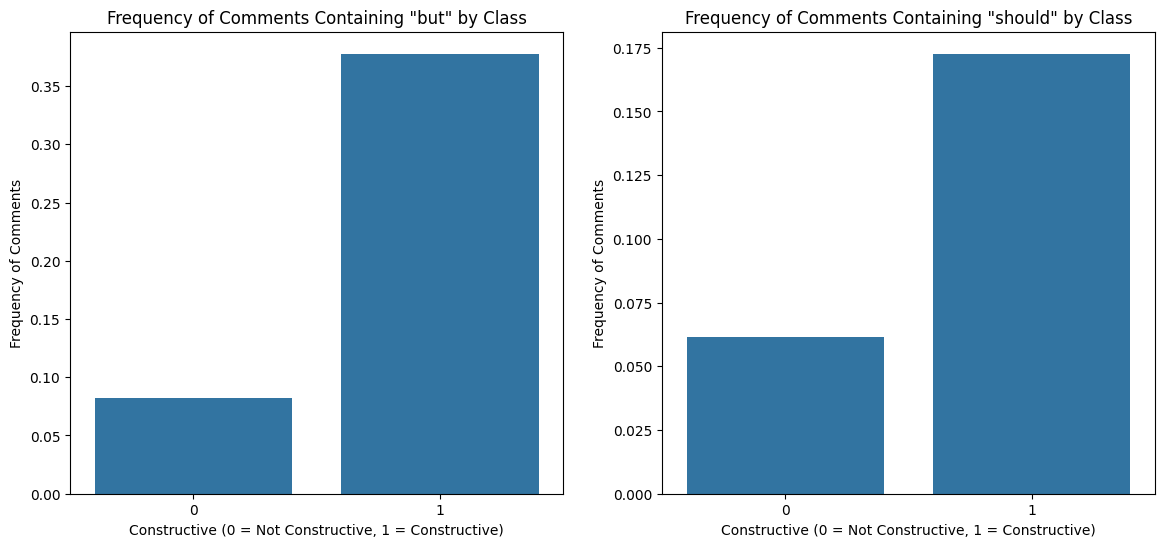

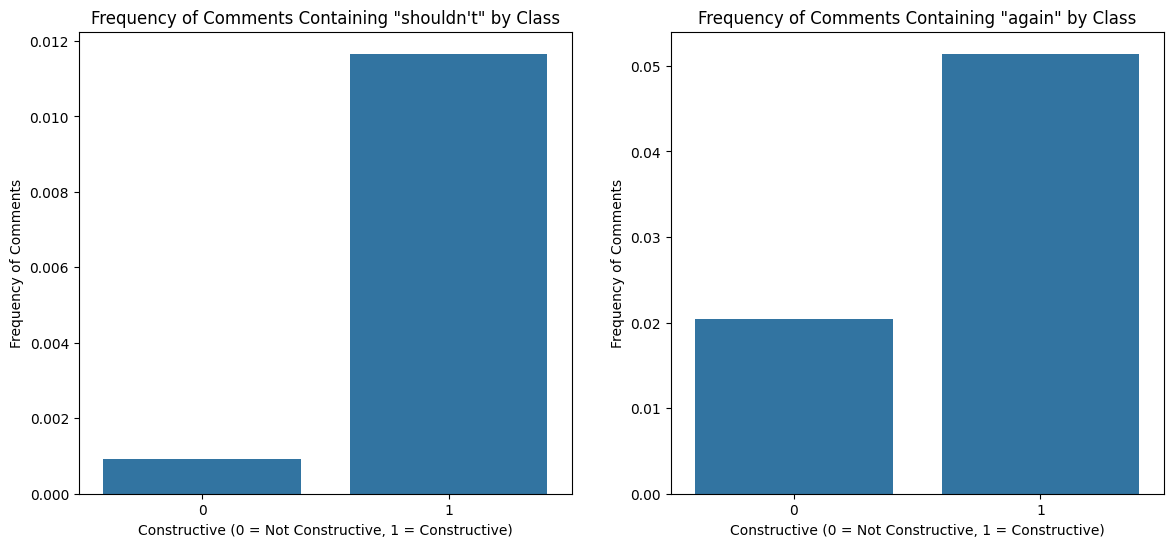

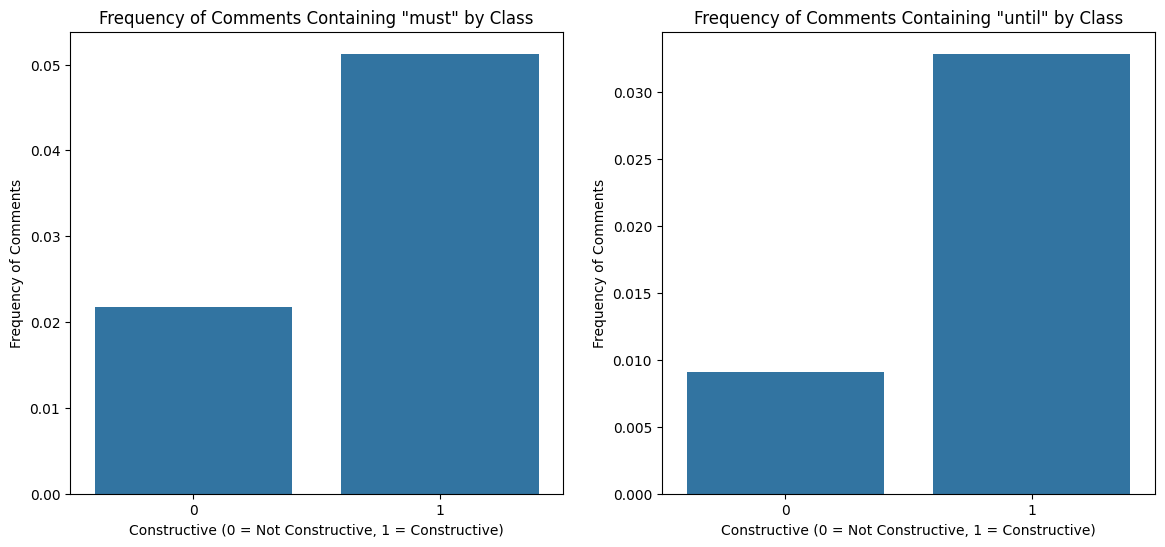

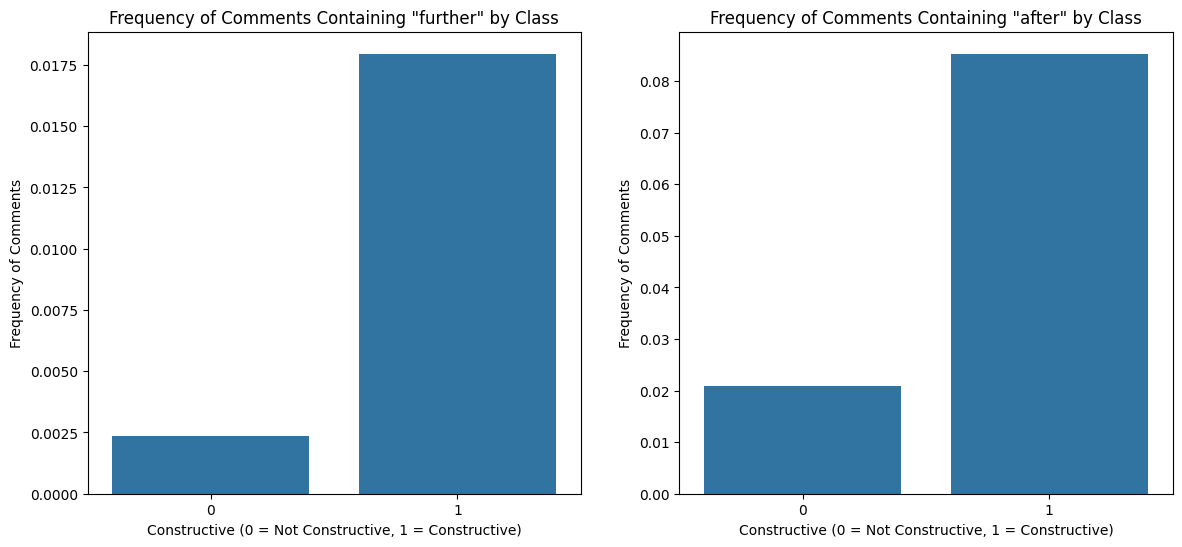

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_word_count_by_class(df_anno, 'but', axes[0])
plot_word_count_by_class(df_anno, 'should', axes[1])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_word_count_by_class(df_anno, "shouldn't", axes[0])
plot_word_count_by_class(df_anno, 'again', axes[1])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_word_count_by_class(df_anno, "must", axes[0])
plot_word_count_by_class(df_anno, "until", axes[1])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_word_count_by_class(df_anno, "further", axes[0])
plot_word_count_by_class(df_anno, "after", axes[1])

In [17]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

We can clearly see that some stopwords have a really different distribution depending on the class, it is then important to keep them in order to keep the most meaning in the sentences and not break the semantic

## Time for Pre-processing!

In [18]:
min_text_length = df_anno['text_length'].min()
min_text_length
## All comments have at least 10 characters, which is acceptable.

# Check for japanese characters
japanese_comments = df_anno[df_anno['comment_text'].str.contains('[\u3040-\u30ff\u3400-\u4dbf\u4e00-\u9fff\uf900-\ufaff\uff66-\uff9f]')]
print(japanese_comments)

# Drop the japanese comments
df_anno = df_anno.drop(japanese_comments.index)

                                                                                                                                                                                                                                                                                                                                 comment_text  \
11598  良い道徳心のカナダ人！私たちは、国レベル、地域レベルや地方レベルに存在する専制政治から私たちの国を解放しません。私たちの国は、ライディングレベルで救出されます。私はハーパー党を代表している人を破っての最善の機会を持っている候補者を決定するためにあなたのライディングにポーリング番号をチェックして、すべての良いカナダ人を促します。この情報はここで見つけることができます。 。 http://www.threehundredeight.com/p/canada.htmlそしてハーパー党に代わって選挙策略や他のごまかしを警戒します。これらは人手不足の方法を採用することは非常に喜んでであることが証明されました。私たちの国は、戦略的な投票によって異なります。   

       constructive_binary  text_length  avg_word_length  
11598                    0          326            108.0  


Load the stanza pipeline to pre-process the data using tokenization

In [23]:
# Create a Stanza pipeline for the English language
nlp = stanza.Pipeline(lang='en', processors='tokenize,lemma,pos')

2024-12-05 19:20:07 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-12-05 19:20:08 INFO: Downloaded file to /Users/gerhardkarbeutz/stanza_resources/resources.json
2024-12-05 19:20:08 WARNING: Language en package default expects mwt, which has been added
2024-12-05 19:20:08 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |

2024-12-05 19:20:08 INFO: Using device: cpu
2024-12-05 19:20:08 INFO: Loading: tokenize
/Users/gerhardkarbeutz/NLP-DetecConstComm-project/venv/lib/python3.10/site-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untru

Converting to CoNLL-U format

In [19]:
df_anno.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11999 entries, 0 to 11999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   comment_text         11999 non-null  object 
 1   constructive_binary  11999 non-null  int64  
 2   text_length          11999 non-null  int64  
 3   avg_word_length      11999 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 468.7+ KB


In [40]:
df_anno.loc[11999]

comment_text           you forget to - or dared not - mention that teachers' unions have the ultimate leverage ....children's' education.
constructive_binary                                                                                                                     0
text_length                                                                                                                           114
avg_word_length                                                                                                                  5.388889
Name: 11999, dtype: object

In [55]:
compare_csv_path = "./Data/compare_file.csv"

df_anno.to_csv(compare_csv_path)

# Number of missing values per column

In [20]:
print(f"Data dimensions are: {df_anno.shape[0]} rows and {df_anno.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{df_anno.index.dtype}")
print(f"\ncolumn types are: \n-----------------\n{df_anno.dtypes}")
index_name = df_anno.index.name
print(f"The index name is: {index_name}")

Data dimensions are: 11999 rows and 4 columns

index types are: 
-----------------
int64

column types are: 
-----------------
comment_text            object
constructive_binary      int64
text_length              int64
avg_word_length        float64
dtype: object
The index name is: None


In [24]:
# Define output file path
output_path = "Data/preprocessed_dataset.conllu"

# Create or open the output file
with open(output_path, 'w', encoding='utf-8') as f:
    # Iterate over each comment in the DataFrame
    for doc_id, comment in enumerate(df_anno["comment_text"]):
        # Process the comment with the Stanza NLP pipeline
        doc = nlp(comment)
        
        # Iterate over each sentence in the processed document
        for sent_id, sentence in enumerate(doc.sentences):
            # Add sentence-level metadata
            f.write(f"# sent_id = {doc_id}_{sent_id}\n")
            f.write(f"# text = {sentence.text}\n")
            
            # Write each token in the sentence in CoNLL-U format
            for word in sentence.words:
                f.write(f"{word.id}\t{word.text}\t{word.lemma}\t{word.upos}\t{word.xpos}\t{word.feats or '_'}\t"
                        f"{word.head}\t{word.deprel}\t_\t_\n")
            
            # Add a blank line after each sentence
            f.write("\n")


### Load CoNLL file

In [25]:
with open(output_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i > 50:  #adjust number of lines to view more or less data
            break
        print(line.strip())


# sent_id = 0_0
# text = And this Conservative strategy has produced the angry and desperate wing-nuts like the fellow who called reporters 'lying pieces of Sh*t' this week.
1	And	and	CCONJ	CC	_	None	None	_	_
2	this	this	DET	DT	Number=Sing|PronType=Dem	None	None	_	_
3	Conservative	Conservative	ADJ	JJ	Degree=Pos	None	None	_	_
4	strategy	strategy	NOUN	NN	Number=Sing	None	None	_	_
5	has	have	AUX	VBZ	Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin	None	None	_	_
6	produced	produce	VERB	VBN	Tense=Past|VerbForm=Part	None	None	_	_
7	the	the	DET	DT	Definite=Def|PronType=Art	None	None	_	_
8	angry	angry	ADJ	JJ	Degree=Pos	None	None	_	_
9	and	and	CCONJ	CC	_	None	None	_	_
10	desperate	desperate	ADJ	JJ	Degree=Pos	None	None	_	_
11	wing	wing	NOUN	NN	Number=Sing	None	None	_	_
12	-	-	PUNCT	HYPH	_	None	None	_	_
13	nuts	nut	NOUN	NNS	Number=Plur	None	None	_	_
14	like	like	ADP	IN	_	None	None	_	_
15	the	the	DET	DT	Definite=Def|PronType=Art	None	None	_	_
16	fellow	fellow	NOUN	NN	Number=Sing	None	None	_	_

In [45]:
with open("./Data/preprocessed_dataset.conllu", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Count sentences and tokens
sentence_count = sum(1 for line in lines if line.startswith("# sent_id"))
token_count = sum(1 for line in lines if line and not line.startswith("#") and not line.strip() == "")

print(f"Number of sentences: {sentence_count}")
print(f"Number of tokens: {token_count}")


Number of sentences: 52412
Number of tokens: 991967


In [48]:
with open("./Data/preprocessed_dataset.conllu", "r", encoding="utf-8") as f:
    lines = f.readlines()

# Check token lines for malformed rows
malformed_rows = [line for line in lines if line and not line.startswith("#") and not line.strip() == "" and len(line.split("\t")) != 10]

print(f"Number of malformed token lines: {len(malformed_rows)}")


Number of malformed token lines: 0


In [52]:
from collections import Counter
upos_counts = Counter(token["upostag"] for sentence in parsed_sentences for token in sentence)
print(upos_counts)



Counter({'NOUN': 172661, 'PUNCT': 111634, 'VERB': 108183, 'ADP': 89451, 'DET': 86005, 'PRON': 80791, 'ADJ': 75946, 'AUX': 66098, 'ADV': 51831, 'PROPN': 49819, 'PART': 32609, 'CCONJ': 31632, 'SCONJ': 19513, 'NUM': 9834, 'INTJ': 2688, 'SYM': 2683, 'X': 589})


In [53]:
sentence_lengths = [len(sentence) for sentence in parsed_sentences]
avg_sentence_length = sum(sentence_lengths) / len(sentence_lengths)
print(f"Average sentence length: {avg_sentence_length:.2f} tokens")


Average sentence length: 18.93 tokens


### Creating new labels using a set of basic rules 

In [15]:
from utils import load_conllu_data, extract_preprocessed_text

file_path = 'Data/preprocessed_dataset.conllu'
features_conllu = load_conllu_data(file_path)
features_conllu.describe()

texts_conllu = extract_preprocessed_text(file_path)

### Rules based on features of the text 

In [26]:
def is_constructive(row):
    if row['num_verbs'] >= 10 and row['num_adjectives'] >= 8 and row['num_tokens'] >= 300:
        return 1  # Constructive
    else:
        return 0  # Not constructive

# Apply the rules to create the 'constructive_category' column
features_conllu['constructive_category'] = features_conllu.apply(is_constructive, axis=1)
print(features_conllu)

features_conllu.to_csv('Data/rule_based_category.csv', index=False)

      comment_id  num_tokens  avg_word_length  num_sentences  num_nouns  \
0              0         161         4.322981              3         35   
1              1         399         4.107769              5         57   
2              2        1451         4.164025             14        208   
3              3         507         4.309665              7         73   
4              4         399         3.884712              7         50   
...          ...         ...              ...            ...        ...   
11994      11994          66         4.106061              2         17   
11995      11995           8         5.500000              1          1   
11996      11996          11         3.636364              1          3   
11997      11997          29         4.896552              1         11   
11998      11998          23         4.217391              1          5   

       num_verbs  num_adjectives  num_adverbs  num_pronouns  num_conjunctions  \
0             17  

In [27]:
print(features_conllu['constructive_category'].value_counts())

constructive_category
0    8731
1    3268
Name: count, dtype: int64


### Rules based on features of the text + keywords

In [80]:
NUM_VERBS = 10
NUM_ADJECTIVES = 8
NUM_TOKENS = 300

# Load csv
vocabulary_constructive = pd.read_csv('Data/vocabulary_constructive.csv')
vocabulary_non_constructive = pd.read_csv('Data/vocabulary_non_constructive.csv')

feautes_with_text = features_conllu.copy()
feautes_with_text['comment_text'] = texts_conllu

def constructive_based_on_features(row):
    if row['num_verbs'] >= 10 and row['num_adjectives'] >= 8 and row['num_tokens'] >= 300:
        return 1  # Constructive
    else:
        return 0  # Not constructive

def constructive_based_on_keywords(row):
    # Count the number of constructive and non-constructive words in the comment
    constructive_count = sum(row['comment_text'].count(word) for word in vocabulary_constructive)
    non_constructive_count = sum(row['comment_text'].count(word) for word in vocabulary_non_constructive)

    # Calculate the ratio of constructive to non-constructive words
    if non_constructive_count > 0:
        return constructive_count / non_constructive_count
    else:
        return constructive_count


def is_constructive_v2(row):
    features_weight = constructive_based_on_features(row)
    keywords_weight = constructive_based_on_keywords(row)

    features_weight = features_weight * 0.7
    keywords_weight = keywords_weight * 0.3

    if features_weight + keywords_weight >= 0.5:
        return 1
    else:
        return 0

# Copy the features DataFrame with only the first 2 rows
feautes_with_text2 = feautes_with_text.head(2).copy()


# Apply the rules to create the 'constructive_category' column
feautes_with_text['constructive_category'] = feautes_with_text.apply(is_constructive_v2, axis=1)

In [81]:
# count 0 in constructive_category for feautes_with_text
print(feautes_with_text['constructive_category'].value_counts())

constructive_category
0    8729
1    3270
Name: count, dtype: int64


In [77]:
feautes_with_text.to_csv('Data/rule_based_category_keywords.csv', index=False)

In [76]:
features_1 = features_conllu[features_conllu['constructive_category'] == 1]
features_keywords_1 = feautes_with_text[feautes_with_text['constructive_category'] == 1]

# Get comments_id that are only in feautes_1 but not in features_keywords_1 and vice versa
comments_id_not_in_keywords = set(features_1['comment_id']) - set(features_keywords_1['comment_id'])
comments_id_not_in_features = set(features_keywords_1['comment_id']) - set(features_1['comment_id'])


comments_id_not_in_features

{'3081', '8111'}